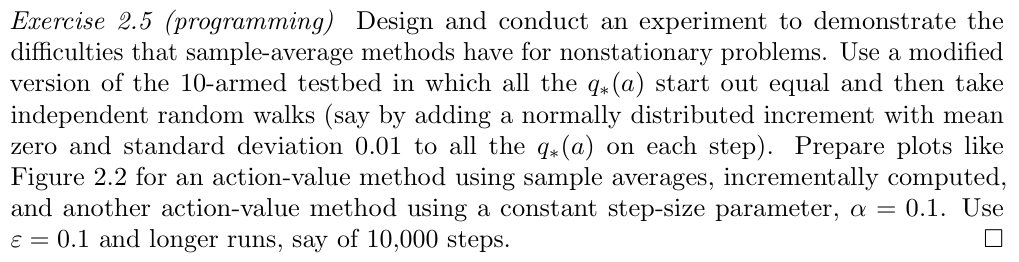

# **non stationary**

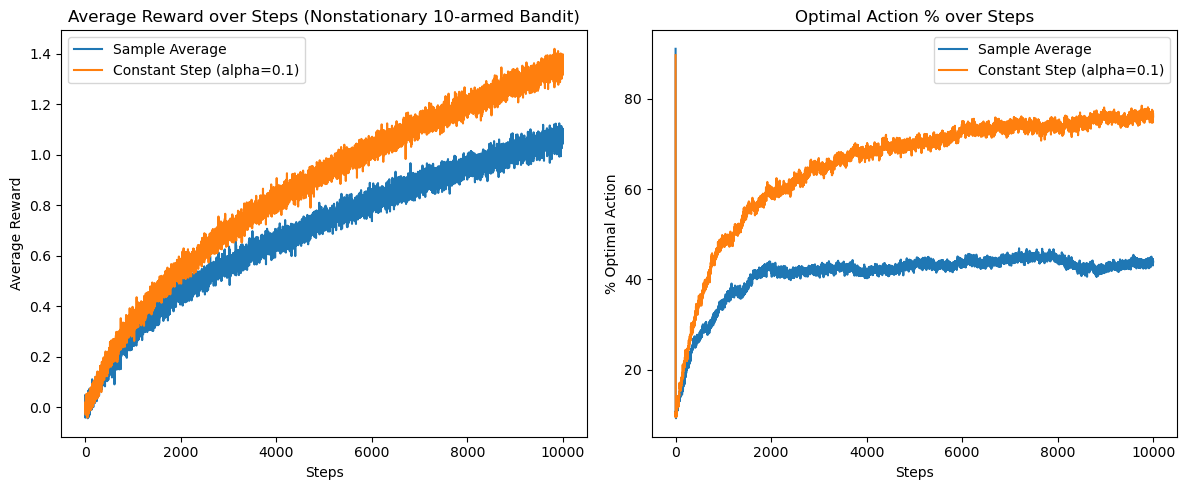

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def run_experiment(n_bandits=10,
                   n_steps=10000, # 에이전트가 10000번 action을 취하고 reward를 얻는다. 
                   n_runs=2000, # 단 한 번의 run만으로는 운에 따른 편차가 크게 나타날 수 있으므로, 
                                # 여러 run의 평균 결과를 봐야 실제 알고리즘의 전반적인 경향과 성능을 올바르게 평가할 수 있다.
                   epsilon=0.1,
                   alpha=0.1,
                   random_walk_std=0.01):
    """
    비정상 10-armed 밴딧 환경에서
    1) 표본 평균 (sample-average)
    2) 고정 학습률 (alpha 고정)
    방식 에이전트의 성능을 비교하는 실험 함수.
    """
    
    # 결과 저장용 (행: runs, 열: steps)
    # sample_average_method
    avg_rewards_sample = np.zeros((n_runs, n_steps))
    optimal_actions_sample = np.zeros((n_runs, n_steps))
    
    # constant_step_method
    avg_rewards_const = np.zeros((n_runs, n_steps))
    optimal_actions_const = np.zeros((n_runs, n_steps))
    
    for run in range(n_runs):
        # ----- 1. 환경 초기화 -----
        # 실제 가치 q_k는 모두 0에서 시작(문제 지시에 따라 "start out equal")
        true_q = np.zeros(n_bandits)
        
        # ----- 2. 에이전트 초기화 -----
        # (1) 표본 평균용 추정치
        Q_est_sample = np.zeros(n_bandits)
        # 각 행동을 몇 번 했는지 기록
        action_count_sample = np.zeros(n_bandits)
        
        # (2) 고정 학습률용 추정치
        Q_est_const = np.zeros(n_bandits)
        
        # 최적 행동의 인덱스 (현재 true_q에서 가장 큰 값을 주는 행동)
        optimal_action = np.argmax(true_q)
        
        # ----- 3. 스텝 반복 -----
        for t in range(n_steps):
            # --- (A) 표본 평균 에이전트 행동 선택 ---
            if np.random.rand() < epsilon:
                action_sample = np.random.randint(n_bandits)
            else:
                action_sample = np.argmax(Q_est_sample)
            
            # --- (B) 고정 학습률 에이전트 행동 선택 ---
            if np.random.rand() < epsilon:
                action_const = np.random.randint(n_bandits)
            else:
                action_const = np.argmax(Q_est_const)
            
            # ----- 4. 환경에서 보상 받기 -----
            # 실제 보상은 true_q[action]를 평균으로 하는 N(true_q[action], 1) 가정(문제2.5 전형)
            reward_sample = np.random.normal(true_q[action_sample], 1.0)
            reward_const = np.random.normal(true_q[action_const], 1.0)
            
            # ----- 5. 추정치 업데이트 -----
            # (1) 표본 평균
            action_count_sample[action_sample] += 1
            # Q_est_sample[action] = Q_est_sample[action] + (1/n) * (R - Q_est_sample[action])
            # 여기서 n은 해당 action이 몇 번 선택되었는지
            n_a = action_count_sample[action_sample]
            Q_est_sample[action_sample] += (1.0 / n_a) * (reward_sample - Q_est_sample[action_sample])

            # Q_est가 변할때는, 새로운 reward가 들어왔을때이다. action이 여러개 있는데 이를 한번에 계산하는게 아니라, 행동마다 
            # Q_est를 따로따로 계산한다. 그래야 행동마다 리워드의 기댓값을 제대로 계산할 수 있다.
            
            # (2) 고정 학습률
            # Q_est_const[action] = Q_est_const[action] + alpha * (R - Q_est_const[action])
            Q_est_const[action_const] += alpha * (reward_const - Q_est_const[action_const])
            
            # ----- 6. 기록 -----
            # (i) 평균 보상
            avg_rewards_sample[run, t] = reward_sample
            avg_rewards_const[run, t] = reward_const
            
            # (ii) 최적 행동 선택 여부
            # 먼저 true_q를 랜덤 워크로 업데이트하기 전에, 현재 시점의 최적 행동을 구함
            current_opt_action = np.argmax(true_q)
            optimal_actions_sample[run, t] = 1 if action_sample == current_opt_action else 0
            optimal_actions_const[run, t] = 1 if action_const == current_opt_action else 0
            
            # ----- 7. 한 스텝 종료 후, true_q에 랜덤 워크 적용 -----
            # 문제 지시: 각 q_k에 N(0, 0.01)을 더해 독립적 랜덤 워크
            true_q += np.random.normal(0.0, random_walk_std, n_bandits)
        
    # ----- 8. 결과(평균) 산출 -----
    mean_rewards_sample = np.mean(avg_rewards_sample, axis=0)
    mean_opt_actions_sample = np.mean(optimal_actions_sample, axis=0)
    
    mean_rewards_const = np.mean(avg_rewards_const, axis=0)
    mean_opt_actions_const = np.mean(optimal_actions_const, axis=0)
    
    return (mean_rewards_sample, mean_opt_actions_sample,
            mean_rewards_const, mean_opt_actions_const)


if __name__ == "__main__":
    # 실험 수행
    (mean_rewards_sample, mean_opt_actions_sample,
     mean_rewards_const, mean_opt_actions_const) = run_experiment()
    
    # 그래프 그리기
    steps = np.arange(len(mean_rewards_sample))
    
    plt.figure(figsize=(12,5))
    
    # (1) 평균 보상 그래프
    plt.subplot(1, 2, 1)
    plt.plot(steps, mean_rewards_sample, label="Sample Average")
    plt.plot(steps, mean_rewards_const, label="Constant Step (alpha=0.1)")
    plt.xlabel("Steps")
    plt.ylabel("Average Reward")
    plt.title("Average Reward over Steps (Nonstationary 10-armed Bandit)")
    plt.legend()
    
    # (2) 최적 행동 선택 비율
    plt.subplot(1, 2, 2)
    plt.plot(steps, mean_opt_actions_sample * 100, label="Sample Average")
    plt.plot(steps, mean_opt_actions_const * 100, label="Constant Step (alpha=0.1)")
    plt.xlabel("Steps")
    plt.ylabel("% Optimal Action")
    plt.title("Optimal Action % over Steps")
    plt.legend()
    
    plt.tight_layout()
    plt.show()